In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import convolve, gaussian_filter
from sklearn.cluster import KMeans

In [3]:
file_path = "data\\assignmentSegmentBrainGmmEmMrf.mat"
with h5py.File(file_path, 'r') as mat_file:
    for key in mat_file.keys():
        print(f"Dataset: {key}, Shape: {mat_file[key].shape}")


Dataset: imageData, Shape: (256, 256)
Dataset: imageMask, Shape: (256, 256)


In [4]:
with h5py.File(file_path, 'r') as mat_file:
    data = np.array(mat_file['imageData'])
    mask = np.array(mat_file['imageMask'])

Text(0.5, 1.0, 'imageMask')

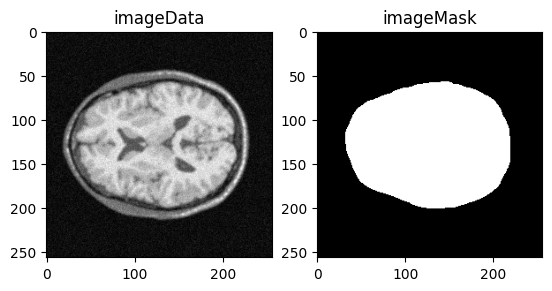

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(data, cmap='gray')
plt.title('imageData')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('imageMask')

(256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


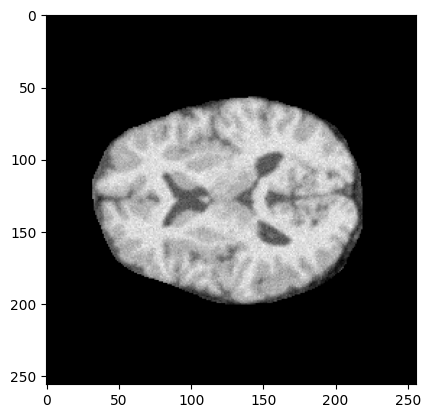

In [6]:
# Multiplying each pixel with the mask to remove the part outside the mask
brainData = data * mask
print(brainData.shape)
plt.imshow(brainData, cmap='gray')
print(brainData)

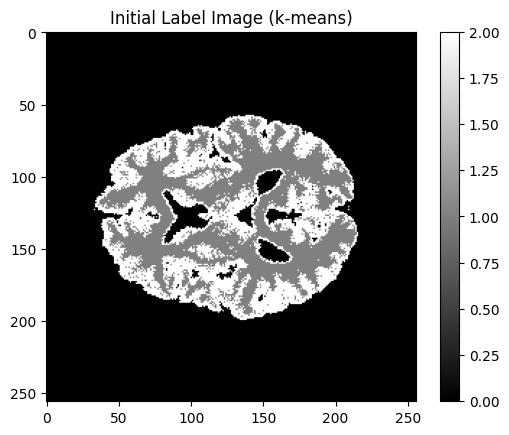

In [11]:
beta=0.5
max_iter=30
tol=1e-4

    
# Load MATLAB file containing corrupted image 'Y' and binary mask 'mask'
data = data
Y = brainData.astype(np.float64)
mask = mask.astype(np.bool_)

# Normalize image intensity to [0, 1]
Y = Y / np.max(Y)

K = 3  # Number of classes

# Work only inside the brain mask
indices = np.where(mask)
n_pixels = len(indices[0])

# ----- Initialization of Label Image using k-means -----
Y_masked = Y[mask].reshape(-1, 1)
kmeans = KMeans(n_clusters=K, random_state=0).fit(Y_masked)
initial_labels = kmeans.labels_
labels = np.zeros_like(Y)
labels[mask] = initial_labels

plt.figure()
plt.imshow(labels, cmap='gray')
plt.title("Initial Label Image (k-means)")
plt.colorbar()
plt.show()

Initial Gaussian parameters:
Class means: [0.35659394 0.83043446 0.66707571]
Class stds: [0.10223052 0.04894442 0.05834879]
Iteration 1, log posterior before ICM: -7772.00, after ICM: -5588.50
Iteration 2, log posterior before ICM: -5588.50, after ICM: -5702.00
Iteration 3, log posterior before ICM: -5702.00, after ICM: -5537.00
Iteration 4, log posterior before ICM: -5537.00, after ICM: -5652.00
Iteration 5, log posterior before ICM: -5652.00, after ICM: -5620.00
Iteration 6, log posterior before ICM: -5620.00, after ICM: -5649.50
Iteration 7, log posterior before ICM: -5649.50, after ICM: -5641.50
Iteration 8, log posterior before ICM: -5641.50, after ICM: -5667.50
Iteration 9, log posterior before ICM: -5667.50, after ICM: -5653.50
Iteration 10, log posterior before ICM: -5653.50, after ICM: -5660.50
Iteration 11, log posterior before ICM: -5660.50, after ICM: -5668.50
Iteration 12, log posterior before ICM: -5668.50, after ICM: -5662.50
Iteration 13, log posterior before ICM: -5662

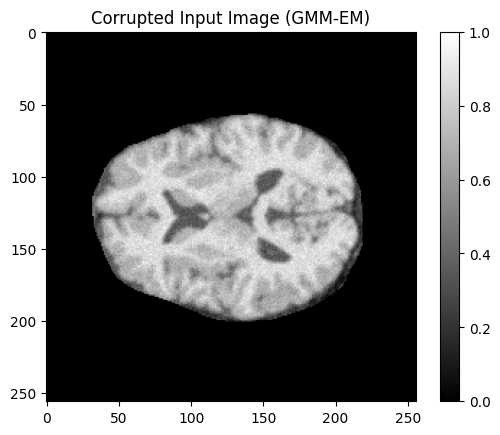

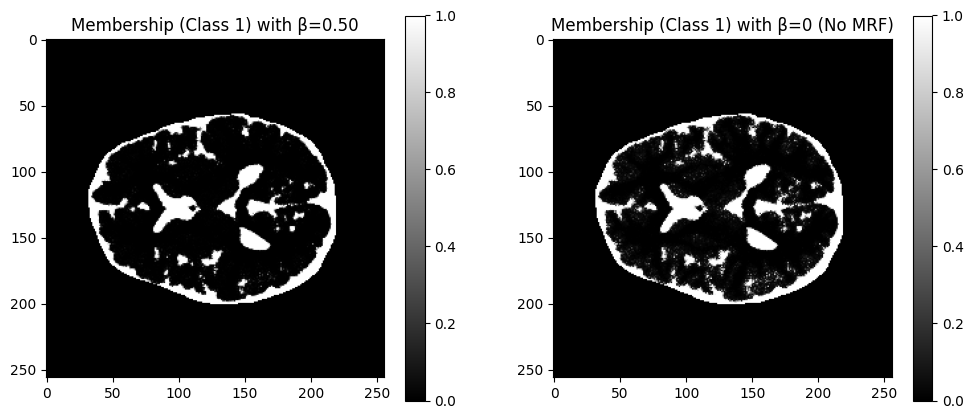

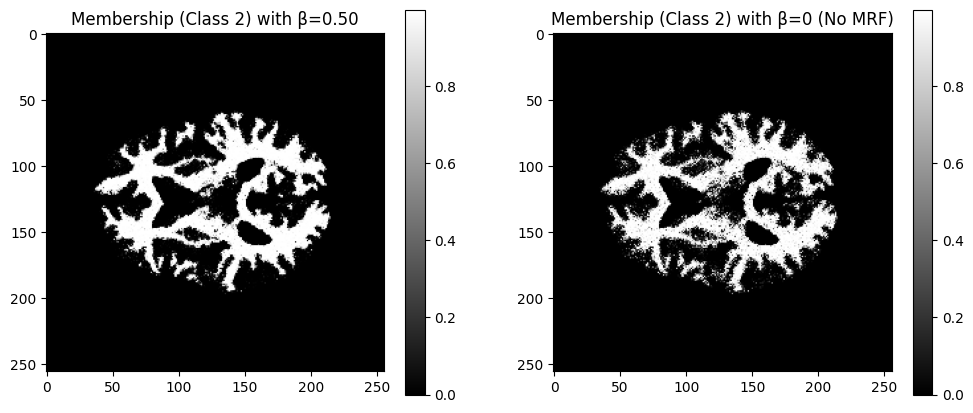

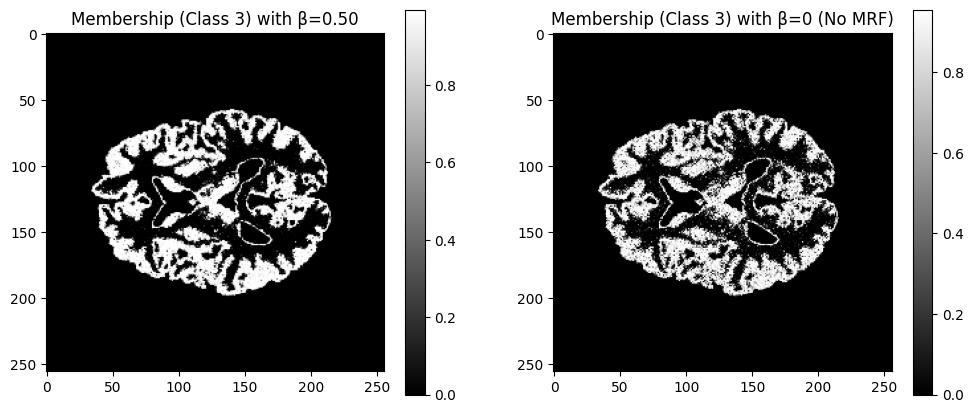

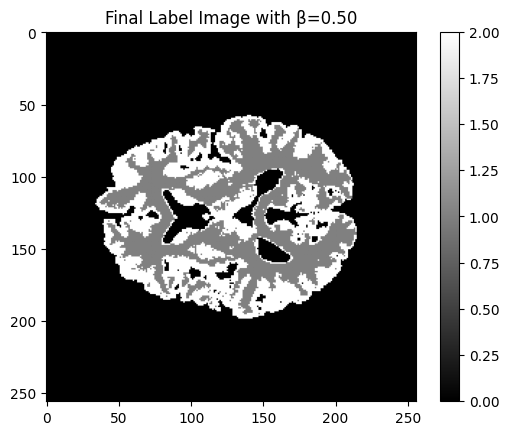

ValueError: cannot reshape array of size 21282 into shape (256,256)

In [12]:

# ----- Initialization of Gaussian Parameters and Memberships -----
class_means = np.zeros(K)
class_stds = np.zeros(K)
memberships = np.zeros((n_pixels, K))
for k in range(K):
    pixels_k = Y[mask][initial_labels == k]
    class_means[k] = np.mean(pixels_k)
    class_stds[k] = np.std(pixels_k) + 1e-10  # to avoid zero std
    memberships[initial_labels == k, k] = 1.0  # hard assignment as initial membership
print("Initial Gaussian parameters:")
print("Class means:", class_means)
print("Class stds:", class_stds)

# To record log posterior probabilities before and after ICM updates
log_posteriors_history = []

# Define a simple function for the MRF prior energy (Potts model) using 4-neighborhood
def mrf_prior(label_img, beta):
    energy = 0
    # 4-neighborhood differences (up, down, left, right)
    for shift in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
        diff = label_img != np.roll(label_img, shift, axis=(0, 1))
        energy += np.sum(diff * mask)
    return -beta * energy  # negative energy gives higher posterior for smooth regions

# ----- EM Iterations -----
for iteration in range(max_iter):
    memberships_old = memberships.copy()
    labels_old = labels.copy()
    
    # E-step: Update membership probabilities based on Gaussian likelihood and MRF prior
    Y_vals = Y[mask]
    likelihood = np.zeros((n_pixels, K))
    for k in range(K):
        coeff = 1.0 / (np.sqrt(2 * np.pi) * class_stds[k])
        exponent = -0.5 * ((Y_vals - class_means[k]) / class_stds[k])**2
        likelihood[:, k] = coeff * np.exp(exponent)
    
    # Compute MRF prior factor for each pixel and class
    # We use a simple scheme: for each pixel, count the number of neighbors that have the same label.
    full_prior = np.zeros((Y.shape[0], Y.shape[1], K))
    kernel_4 = np.array([[0, 1, 0],
                            [1, 0, 1],
                            [0, 1, 0]])
    for k in range(K):
        label_k = (labels == k).astype(np.float64)
        count_neighbors = convolve(label_k, kernel_4, mode='reflect')
        full_prior[:, :, k] = np.exp(beta * count_neighbors)
    prior_factor = np.zeros((n_pixels, K))
    for idx, (i, j) in enumerate(zip(indices[0], indices[1])):
        for k in range(K):
            prior_factor[idx, k] = full_prior[i, j, k]
    
    membership_numerators = likelihood * prior_factor
    membership_denoms = np.sum(membership_numerators, axis=1, keepdims=True) + 1e-10
    memberships = membership_numerators / membership_denoms
    
    # M-step: Update Gaussian parameters using weighted averages
    for k in range(K):
        weights = memberships[:, k]
        class_means[k] = np.sum(weights * Y_vals) / (np.sum(weights) + 1e-10)
        class_stds[k] = np.sqrt(np.sum(weights * (Y_vals - class_means[k])**2) / (np.sum(weights) + 1e-10))
    
    # ICM update: Update label image by maximizing the local log posterior
    new_labels = np.copy(labels)
    for idx, (i, j) in enumerate(zip(indices[0], indices[1])):
        y_val = Y[i, j]
        posteriors = np.zeros(K)
        for k in range(K):
            ll = -0.5 * np.log(2*np.pi*class_stds[k]**2) - 0.5 * ((y_val - class_means[k])**2)/(class_stds[k]**2)
            # MRF term: count matching labels in the 4-neighborhood
            neighbors = []
            for di, dj in [(0,1), (1,0), (0,-1), (-1,0)]:
                ni, nj = i + di, j + dj
                if 0 <= ni < Y.shape[0] and 0 <= nj < Y.shape[1] and mask[ni, nj]:
                    neighbors.append(1 if labels[ni, nj]==k else 0)
            mrf_energy = beta * np.sum(neighbors)
            posteriors[k] = ll + mrf_energy
        new_labels[i, j] = np.argmax(posteriors)
    
    # Record log posterior before and after ICM update using the defined MRF prior
    log_post_before = mrf_prior(labels, beta)
    log_post_after = mrf_prior(new_labels, beta)
    log_posteriors_history.append((log_post_before, log_post_after))
    print(f"Iteration {iteration+1}, log posterior before ICM: {log_post_before:.2f}, after ICM: {log_post_after:.2f}")
    
    labels = new_labels
    
    # Convergence check based on memberships
    if np.linalg.norm(memberships - memberships_old) < tol:
        print("EM Convergence reached at iteration", iteration+1)
        break

# Display final corrupted image
plt.figure()
plt.imshow(Y, cmap='gray')
plt.title("Corrupted Input Image (GMM-EM)")
plt.colorbar()
plt.show()

# Compute and display membership maps with and without MRF prior (β = given and β = 0)
likelihood_noMRF = np.zeros((n_pixels, K))
for k in range(K):
    coeff = 1.0 / (np.sqrt(2 * np.pi) * class_stds[k])
    exponent = -0.5 * ((Y_vals - class_means[k]) / class_stds[k])**2
    likelihood_noMRF[:, k] = coeff * np.exp(exponent)
memberships_noMRF = likelihood_noMRF / (np.sum(likelihood_noMRF, axis=1, keepdims=True) + 1e-10)

for k in range(K):
    mem_img_mrf = np.zeros_like(Y)
    mem_img_noMRF = np.zeros_like(Y)
    mem_img_mrf[mask] = memberships[:, k]
    mem_img_noMRF[mask] = memberships_noMRF[:, k]
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(mem_img_mrf, cmap='gray')
    plt.title(f"Membership (Class {k+1}) with β={beta:.2f}")
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(mem_img_noMRF, cmap='gray')
    plt.title(f"Membership (Class {k+1}) with β=0 (No MRF)")
    plt.colorbar()
    plt.show()

# Display final label image with MRF prior
plt.figure()
plt.imshow(labels, cmap='gray')
plt.title(f"Final Label Image with β={beta:.2f}")
plt.colorbar()
plt.show()

results = {
    'labels': labels,
    'memberships': [np.reshape(memberships[:, k], mask.shape) for k in range(K)],
    'class_means': class_means,
    'class_stds': class_stds,
    'log_posteriors': log_posteriors_history,
    'beta': beta
}

